In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../gmm_dataset_c5k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32

BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'baseline-mlp-%dsamples' % (SAMPLE_SIZE)
DEVICE = torch.device('cuda:0')

Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (N, K, D)

In [3]:
from local_enc import *
from global_oneshot import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_z)

In [4]:
from os_ep import *
train(models, EP, optimizer, Data, Model_Params, Train_Params)

epoch: 0\1000 (2s),  eubo: -1037.803,  elbo: -1299.873,  ess: 1.023,  kl_eta_ex: 974.965,  kl_eta_in: 150.283,  kl_z_ex: 367.565,  kl_z_in: 41.604
epoch: 1\1000 (2s),  eubo: -953.416,  elbo: -1190.187,  ess: 1.026,  kl_eta_ex: 869.002,  kl_eta_in: 142.991,  kl_z_ex: 328.449,  kl_z_in: 38.983
epoch: 2\1000 (2s),  eubo: -878.459,  elbo: -1093.443,  ess: 1.033,  kl_eta_ex: 774.253,  kl_eta_in: 136.055,  kl_z_ex: 294.778,  kl_z_in: 36.657
epoch: 3\1000 (2s),  eubo: -811.786,  elbo: -1008.495,  ess: 1.033,  kl_eta_ex: 690.310,  kl_eta_in: 129.485,  kl_z_ex: 264.460,  kl_z_in: 34.638
epoch: 4\1000 (2s),  eubo: -753.788,  elbo: -931.971,  ess: 1.040,  kl_eta_ex: 616.077,  kl_eta_in: 123.224,  kl_z_ex: 236.428,  kl_z_in: 32.757
epoch: 5\1000 (2s),  eubo: -705.111,  elbo: -866.016,  ess: 1.046,  kl_eta_ex: 549.957,  kl_eta_in: 117.457,  kl_z_ex: 212.228,  kl_z_in: 30.990
epoch: 6\1000 (2s),  eubo: -658.808,  elbo: -804.686,  ess: 1.045,  kl_eta_ex: 489.906,  kl_eta_in: 111.940,  kl_z_ex: 188.46

In [5]:
torch.save(enc_z.state_dict(), '../weights/enc-z-%s' + PATH)
torch.save(oneshot_eta.state_dict(), '../weights/oneshot-eta-%s' + PATH)

In [12]:
def test(models, objective, Data, Model_Params, Train_Params):
    (NUM_EPOCHS, NUM_DATASETS, S, B, CUDA, device, path) = Train_Params
    SubTrain_Params = (device, S, B) + Model_Params
    ##(N, K, D, mcmc_size) = Model_Params
    indices = torch.randperm(NUM_DATASETS)
    batch_indices = indices[0*B : (0+1)*B]
    obs = Data[batch_indices]
    obs = shuffler(obs).repeat(S, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(device)
    loss, metric_step, reused = objective(models, obs, SubTrain_Params)
    return obs, metric_step, reused

In [13]:
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
obs, metric_step, reused = test(models, EP, Data, Model_Params, Train_Params_Test)
(q_eta, _, q_z, _, _, _) = reused

CPU times: user 2.18 s, sys: 20.3 ms, total: 2.2 s
Wall time: 2.2 s


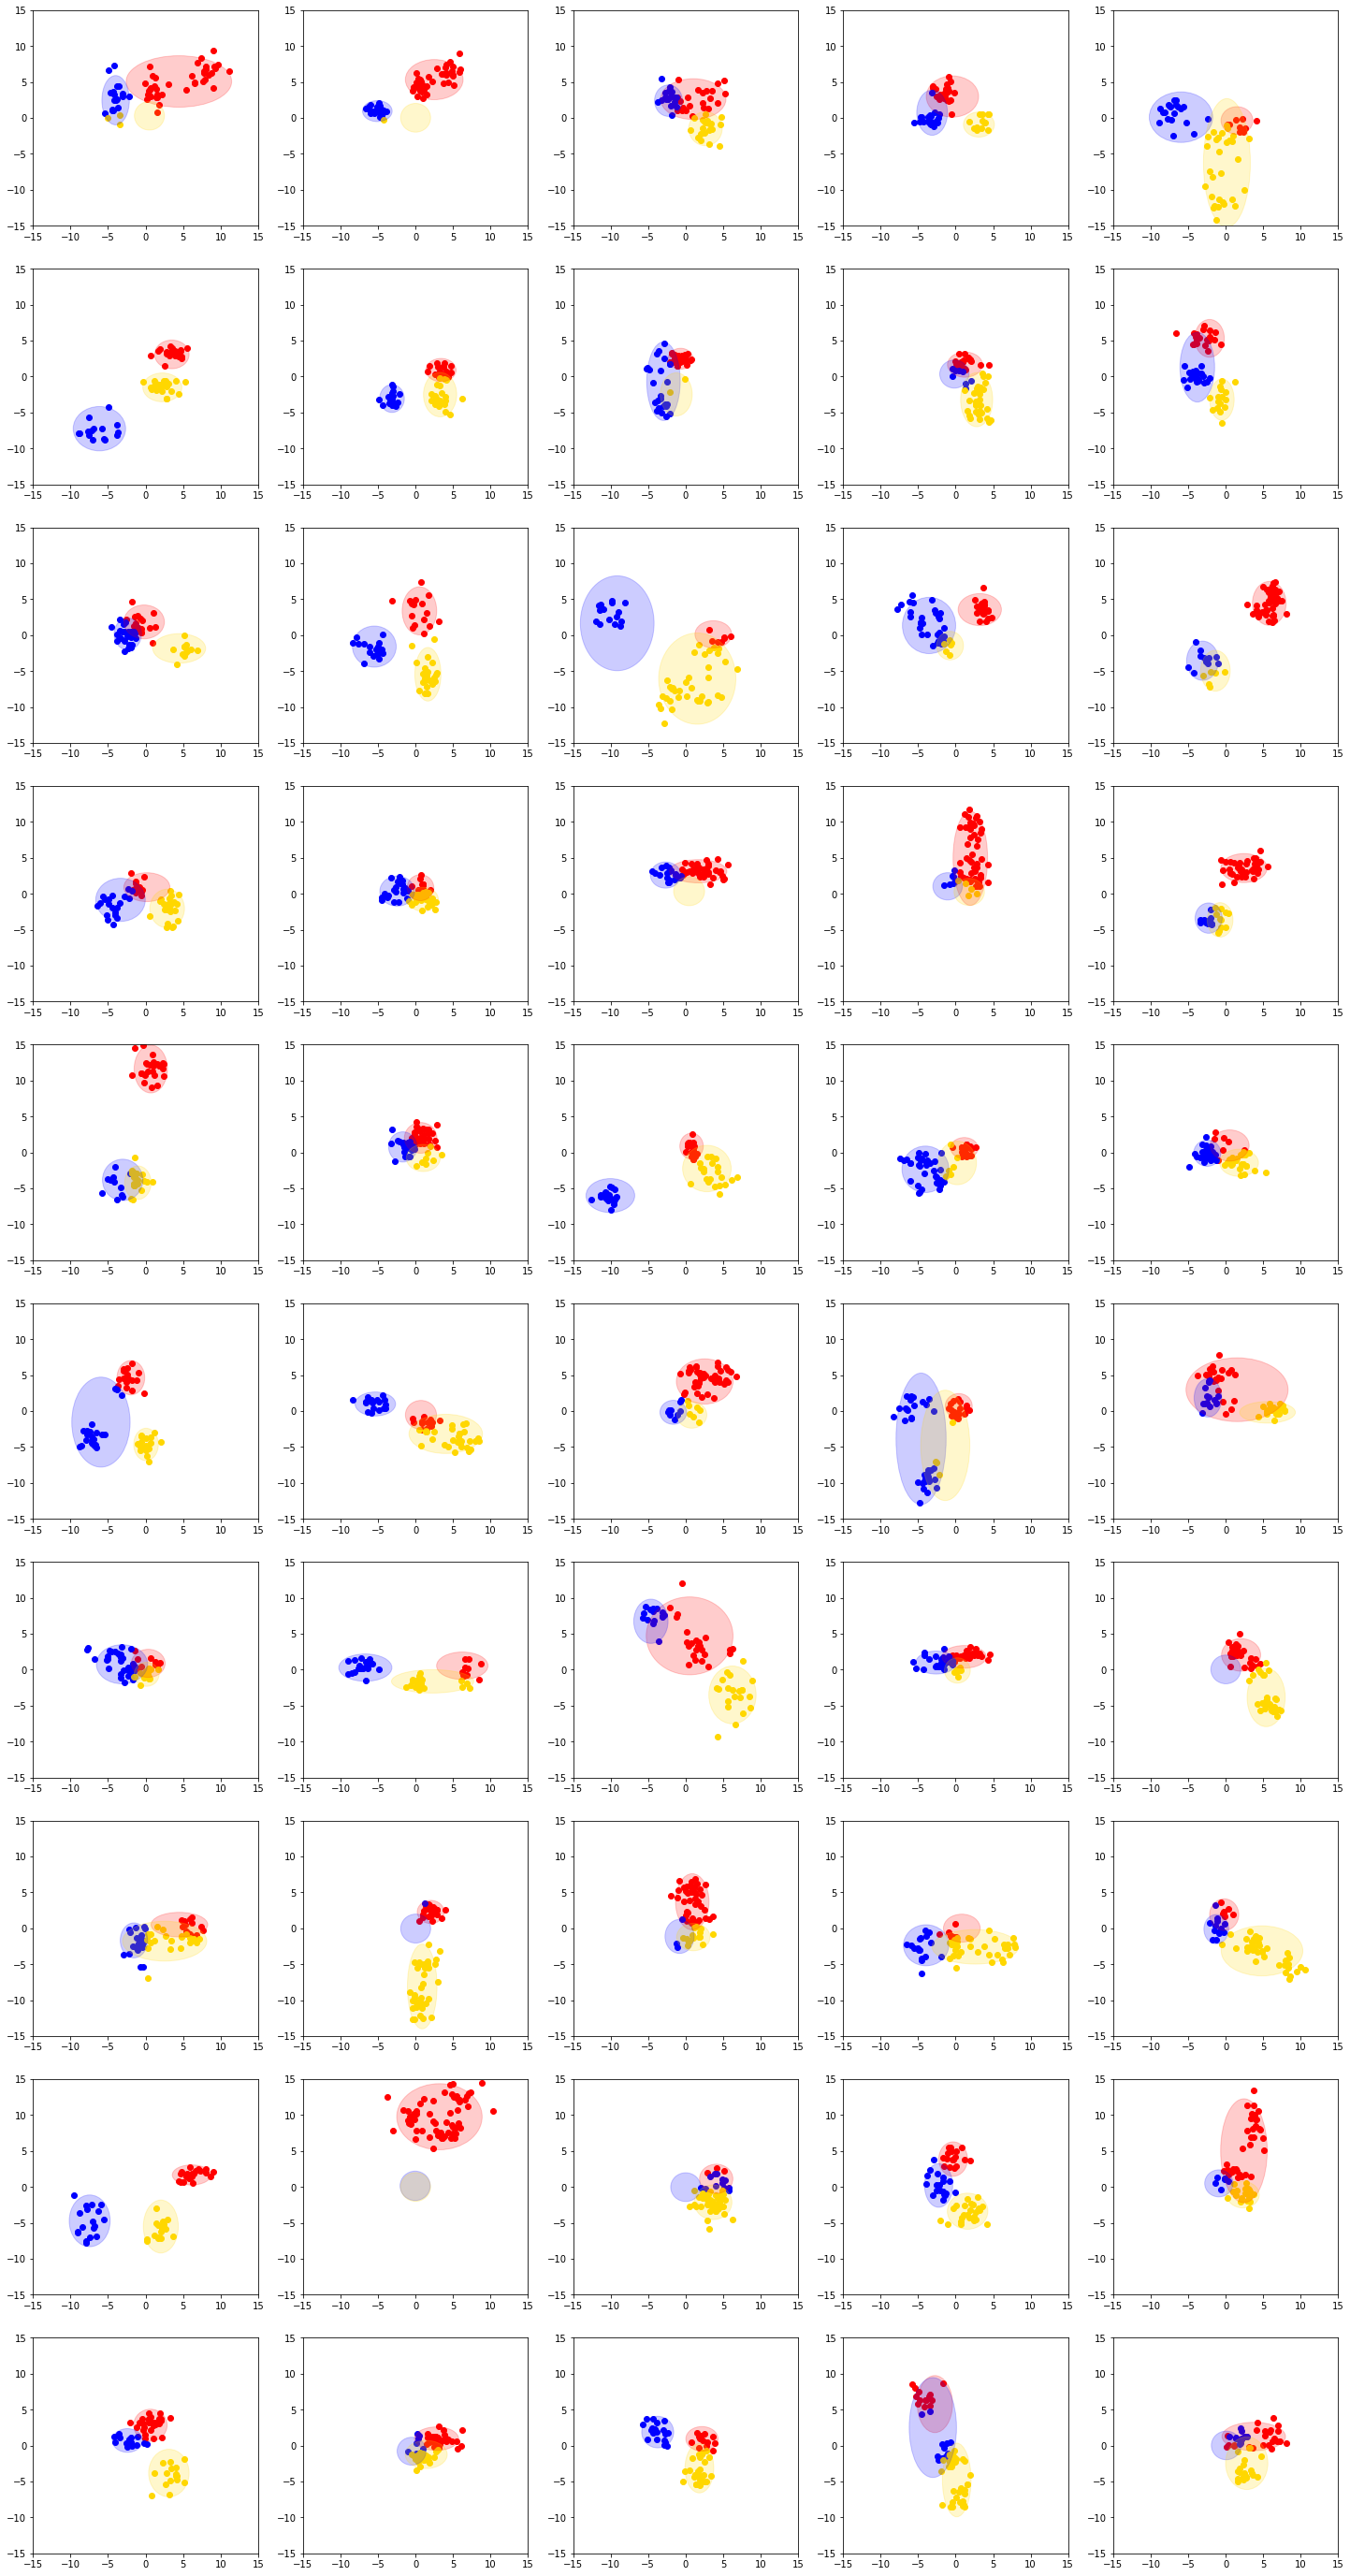

In [14]:
%time plot_samples(obs, q_eta, q_z, PATH)

In [ ]:
incremental_gap = symkl_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')

In [ ]:
incremental_gap